<a href="https://colab.research.google.com/github/Qwerci/Pneumonia_xray_classification/blob/main/Pneumonia_lungs_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import numpy as np
import cv2

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from PIL import Image
from IPython.display import display

import torch
import torch.nn as nn

from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torchsummary import summary
from tqdm import tqdm

In [3]:
from google.colab import drive
drive.mount('/content/drive/')
!unzip '/content/drive/MyDrive/Projects/CNN Classification/archive(2).zip'

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/NORMAL-2558319-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2558319-0002.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2559035-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2559035-0002.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2565226-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2568157-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2597757-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2597757-0002.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-263932-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2646645-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2646923-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2655558-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2659844-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2675017-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2675017-00

In [4]:
data_path = '/content/chest_xray'

##Data Exploration

In [5]:
class_name = ['NORMAL','PNEUMONIA']
def get_list_files(m_dir):
  files_list = os.listdir(m_dir)
  return files_list

In [6]:
files_list_normal_train = get_list_files(data_path+'/train/'+class_name[0])
files_list_pneu_train = get_list_files(data_path+'/train/'+class_name[1])
files_list_normal_test = get_list_files(data_path+'/test/'+class_name[0])
files_list_pneu_test = get_list_files(data_path+'/test/'+class_name[1])

In [7]:
print("Number of train samples in Normal category {}".
format(len(files_list_normal_train)))
print("Number of train samples in Pneumonia category {}".
format(len(files_list_pneu_train)))
print("Number of test samples in Normal category {}".
format(len(files_list_normal_test)))
print("Number of test samples in Pneumonia category {}".
format(len(files_list_pneu_test)))

Number of train samples in Normal category 1349
Number of train samples in Pneumonia category 3883
Number of test samples in Normal category 234
Number of test samples in Pneumonia category 390


Viewing sample image


In [8]:
rand_img_no = np.random.randint(0,len(files_list_normal_train))
img = data_path + '/train/NORMAL/' + files_list_normal_train[rand_img_no]
print(plt.imread(img).shape)

(1615, 1890)


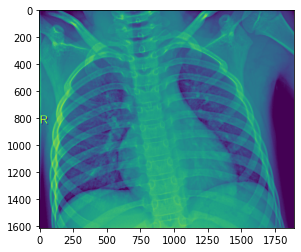

In [9]:
samp_img = mpimg.imread(img)
imgplot = plt.imshow(samp_img)
plt.show()

In [10]:
img = data_path + '/train/PNEUMONIA/' + files_list_pneu_train[np.random.randint(0,len(files_list_pneu_train))]
print(plt.imread(img).shape)

(880, 1336)


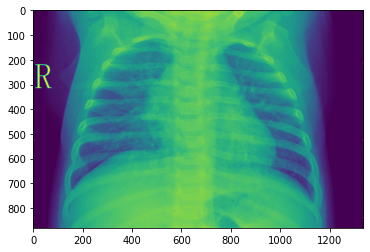

In [11]:
samp_img = mpimg.imread(img)
imgplot = plt.imshow(samp_img)
plt.show()

##Data Loaders

In [12]:
train_transform = transforms.Compose([
    transforms.Resize(200),
    transforms.CenterCrop(200),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(200),
    transforms.CenterCrop(200),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [13]:
train_data = datasets.ImageFolder(os.path.join(data_path,'train'),train_transform)
test_data = datasets.ImageFolder(os.path.join(data_path,'test'),test_transform)

In [17]:
train_loader = DataLoader(train_data,
                          batch_size=16, shuffle=True,pin_memory=True)

test_loader = DataLoader(test_data,
                         batch_size=16, shuffle=False, pin_memory=True)

class_names = train_data.classes
print(class_names)
print(f'Number of train images: {len(train_data)}')
print(f'Number of test images: {len(test_data)}')

['NORMAL', 'PNEUMONIA']
Number of train images: 5232
Number of test images: 624


#Model

In [ ]:
from numpy.ma.core import sqrt
from torch.functional import chain_matmul
from torch.nn.modules.container import Sequential
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.convblock1 = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=8, kernel_size=(3,3),
                  padding=0, bias=False),
        nn.ReLU()

    )
    self.pool11 = nn.MaxPool2d(2,2)

    # Convolution Block
    self.convblock2 = nn.Sequential(
        nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3,3),
                  padding=0, bias = False),
        nn.ReLU()
    )
    self.pool22 = nn.MaxPool2d(2,2)

    # Transition Block
    self.convblock3 = nn.Sequential(
        nn.Conv2d(in_channels=16, out_channels=10, kernel_size = (1,1),
                  padding = 0, bias=False),
        nn.ReLU()
    )
    self.pool33 = nn.MaxPool2d(2,2)

    # Convolution Block
    self.convblock4 = nn.Sequential(
        nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3,3),
                  padding=0, bias = False),
        nn.ReLU()
    )
    

    # Convolution Block
    self.convblock5 = nn.Sequential(
        nn.Conv2d(in_channels=10, out_channels=32, kernel_size=(1,1),
                  padding=0, bias=False),
        nn.ReLU()
    )
    
    self.convblock6 =nn.Sequential(
        nn.Conv2d(in_channels=32,out_channels=10,kernel_size=(1,1),
                  padding=0,bias = False),
        nn.ReLU()
    )

    self.convblock7= nn.Sequential(
        nn.Conv2d(in_channels=10,out_channels=10,kernel_size=(3,3),
                  padding = 0, bias=False),
        nn.ReLU()
    )

    self.convblock8=nn.Sequential(
        nn.Conv2d(in_channels=10,out_channels=32,kernel_size =(1,1),
                    padding=0, bias=False),
        nn.ReLU()
    )

    self.convblock9 =nn.Sequential(
        nn.Conv2d(in_channels=32,out_channels=10,kernel_size=(1,1),
                  padding=0,bias=False),
        nn.ReLU()
    )

    self.convblock10=nn.Sequential(
        nn.Conv2d(in_channels=10,out_channels=14,kernel_size =(3,3),
                    padding=0, bias=False),
        nn.ReLU()
    )

    self.convblock11=nn.Sequential(
        nn.Conv2d(in_channels=14,out_channels=16,kernel_size =(3,3),
                    padding=0, bias=False),
        nn.ReLU()
    )

    # Output Block
    self.gap = nn.Sequential(
        nn.AvgPool2d(kernel_size=4)
    )

    self.convblockout = nn.Sequential(
        nn.Conv2d(in_channels=16, out_channels=2, kernel_size=(4,4),
                  padding=0, bias=False)
    )

  def forward(self,x):
    x=self.convblock1(x)
    x=self.pool11(x)
    x=self.convblock2(x)
    x=self.pool22(x)
    x=self.convblock3(x)
    x=self.pool33(x)
    x=self.convblock4(x)
    x=self.convblock5(x)
    x=self.convblock6(x)
    x=self.convblock7(x)
    x=self.convblock8(x)
    x=self.convblock9(x)
    x=self.convblock10(x)
    x=self.convblock11(x)
    x=self.gap(x)
    x=self.convblockout(x)

    x =x.view(-1,2)
    return F.log_softmax(x, dim =-1)
    

                